<a href="https://colab.research.google.com/github/Bibhash123/Resizing_factor_estimation/blob/main/UCR_RF_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [6]:
import cv2
import os
import numpy as np
import random
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt

In [7]:
def seedAll(seed=355):
  random.seed(seed)
  np.random.seed(seed)
  tf.random.set_seed(seed)
  os.environ["PYTHONHASHSEED"]=str(seed)

seedAll()

# Data Prep

In [8]:
PATH ='/content/gdrive/My Drive/Sync/ML4E-Forensics/uncompressed/UNcompressed/'
WRITE_PATH = '/content/UCR/'
CAND_RF = [0.5,0.6,0.7,0.8,0.9,1.1,1.2,1.3,1.4,1.5]
CROP_SIZE = 128

In [9]:
def extract_images(img,crop_size=256):
    images = []
    for i in range(crop_size,img.shape[0],crop_size):
        for j in range(crop_size,img.shape[1],crop_size):
            images.append(img[i-crop_size:i,j-crop_size:j,:])
    return images

def crop_img(img):

  img = img[0:CROP_SIZE,0:CROP_SIZE,:]
  return img

In [10]:
images = []
total = len(os.listdir(PATH))
test = []

for id,img in enumerate(os.listdir(PATH)):
  print(f'\rProgress: {(id+1)*100/total} %',end='',flush=True)
  try:
    image = cv2.cvtColor(cv2.imread(PATH+img),cv2.COLOR_BGR2RGB)
    temp = extract_images(image)
    test = test+temp[0::20]
    del temp[0::20]
    images = images+temp
  except:
    pass

Progress: 100.0 %

In [11]:
print(f"train+val set size: {len(images)}")
print(f"holdout set size: {len(test)}")

train+val set size: 12689
holdout set size: 690


In [12]:
def prepare_data(images,folder="Train",rfs=CAND_RF):
  l = len(images)
  img_shape = images[0].shape
  
  print(f'Resizing {l} images with 5 of {len(rfs)} candidate factors')
  for id,img in enumerate(images):
    print(f'\rProgress: {(id+1)*100/l} %',end='',flush=True)
    
    for factor in np.random.choice(rfs,5,replace=False):
      rs_size = (int(img_shape[0]*factor),int(img_shape[1]*factor))
      rs_img = cv2.resize(img,rs_size,interpolation=cv2.INTER_CUBIC)
      rs_img = cv2.cvtColor(crop_img(rs_img),cv2.COLOR_RGB2BGR)
      cv2.imwrite(WRITE_PATH+folder+f'/img_{id}_RF_{factor}.TIF',rs_img)
  print('')
prepare_data(images)
prepare_data(test,folder="Test")

Resizing 12689 images with 5 of 10 candidate factors
Progress: 100.0 %
Resizing 690 images with 5 of 10 candidate factors
Progress: 100.0 %


In [13]:
tr_dir = os.listdir(WRITE_PATH+"Train/")
print(f"final train+val set size: {len(tr_dir)}")
te_dir = os.listdir(WRITE_PATH+"Test/")
print(f"final holdout set size: {len(te_dir)}")

final train+val set size: 63445
final holdout set size: 3450


# Model Trainining

In [14]:
PATH = '/content/UCR/'
CAND_RF = [0.5,0.6,0.7,0.8,0.9,1.1,1.2,1.3,1.4,1.5]
CROP_SIZE = 128

In [15]:
os.listdir(PATH+'Train/')[0]

'img_4664_RF_1.4.TIF'

In [28]:
class DataLoader:
  def __init__(self,path=None):
    """ 
    custom ImageDataGenerator Object
    ++++++++++++++++++++++++++++++++++++++++++
    path: path to directory of images

    Example:

    data = DataLoader(path="/content/gdrive/My Drive/Sync/UCR/Train)
    loader = data.flow(batch_size=64)
    model.fit_generator(loader)
    """
    self.files = os.listdir(path)
    np.random.shuffle(self.files)
    self.path = path

  def extract_label(self,a):
    return float(a.split('_')[-1].split('TIF')[0][:-1])

  def image_reader(self,files):
    for img in files:
      im = cv2.cvtColor(cv2.imread(self.path+img),cv2.COLOR_BGR2YCrCb)[:,:,0]
      im = np.expand_dims(im,axis=2)
      lab = self.extract_label(img)
      label = np.zeros(10)
      label[CAND_RF.index(lab)] = 1
      yield im,label
  
  def batch_generator(self,items,batch_size):
    a=[]
    i=0
    for item in items:
      a.append(item)
      i+=1

      if i%batch_size==0:
        yield a
        a=[]
    if len(a) is not 0:
      yield a
  
  def flow(self,batch_size):
    """
    flow from given directory in batches
    ==========================================
    batch_size: size of the batch
    """
    path = self.files
    while True:
      for bat in self.batch_generator(self.image_reader(path),batch_size):
        batch_images = []
        batch_labels = []
        for im,im_label in bat:
          batch_images.append(im)
          batch_labels.append(im_label)
        batch_images = np.stack(batch_images,axis=0)
        batch_labels =  np.stack(batch_labels,axis=0)
        yield batch_images,batch_labels

In [17]:
def build_model():
  inp = L.Input(shape=(128,128,1))
  out = L.Conv2D(32,(3,3),activation="relu",kernel_initializer="lecun_normal")(inp)
  side = out
  out = L.Conv2D(32,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(out)
  out = L.Conv2D(32,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(out)


  out = L.Add()([out,side])
  out = L.Conv2D(64,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(out)
  side2 = out
  out = L.Conv2D(64,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(out)
  out = L.Conv2D(64,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(out)
  out = L.MaxPooling2D(pool_size=(2,2))(out)
  
  side2 = L.Conv2D(64,(1,1),strides=2,activation=None)(side2)
  out = L.Add()([out,side2])
  out = L.GlobalAveragePooling2D()(out)
  out = L.Dense(120,activation="relu",kernel_initializer="he_normal")(out)
  out = L.Dense(50,activation="relu",kernel_initializer="he_normal",kernel_regularizer=tf.keras.regularizers.L2(0.01))(out)
  out = L.Dense(10,activation="softmax",kernel_initializer="he_normal")(out)

  model = tf.keras.Model(inputs=inp,outputs=out)
  model.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adamax(lr=0.001),metrics=["accuracy"])
  return model

In [32]:
model = build_model()
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 126, 126, 32) 320         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 126, 126, 32) 9248        conv2d_7[0][0]                   
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 126, 126, 32) 9248        conv2d_8[0][0]                   
_______________________________________________________________________________________

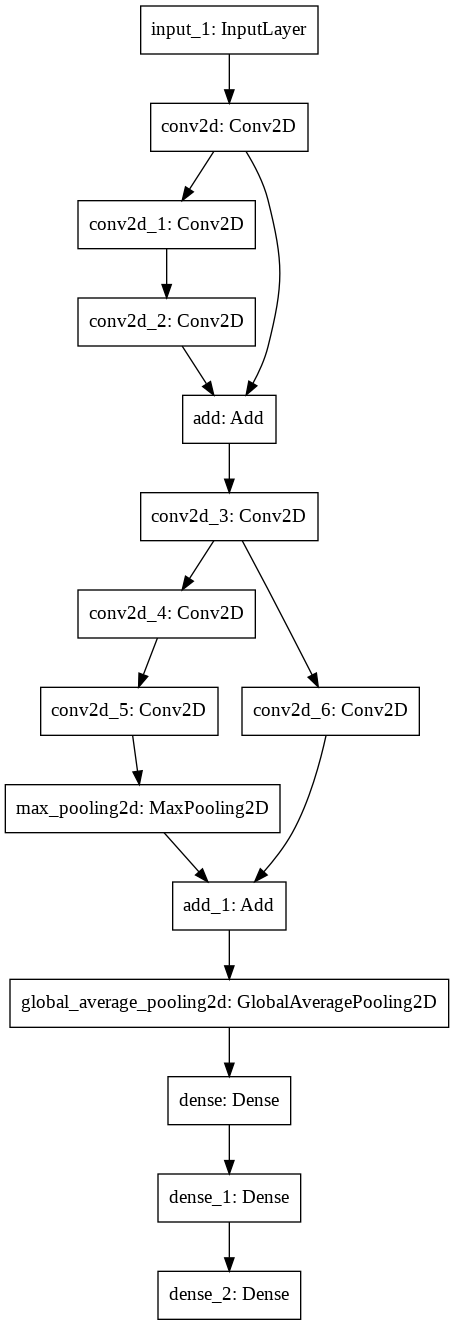

In [19]:
tf.keras.utils.plot_model(model)

In [33]:
chckpt = tf.keras.callbacks.ModelCheckpoint('model.hdf5',save_best_only=True,save_weights_only=True,monitor="val_accuracy",mode="max")

In [34]:
from IPython.display import clear_output
class loss_plt(tf.keras.callbacks.Callback):
  def on_train_begin(self,logs={}):
    self.losses = []
    self.val_losses =[]
    self.accuracy = []
    self.val_accuracy =[]

  def on_epoch_end(self,epoch,logs={}):
    clear_output(wait=True)
    self.val_losses.append(logs.get('val_loss'))
    self.losses.append(logs.get('loss'))

    self.val_accuracy.append(logs.get('val_accuracy'))
    self.accuracy.append(logs.get('accuracy'))

    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.plot(self.val_losses,color="green",label="val_loss")
    plt.plot(self.losses,color="red",label="loss")
    plt.legend()
    plt.title("loss curve");

    plt.subplot(1,2,2)
    plt.plot(self.val_accuracy,color="green",label="val_accuracy")
    plt.plot(self.accuracy,color="red",label="accuracy")
    plt.legend()
    plt.title("accuracy curve");
    plt.tight_layout()
    plt.show()

loss_cback = loss_plt()

In [36]:
val_X = []
val_Y = []
l = len(os.listdir(PATH+"Test/"))

def extract_label(a):
    return float(a.split('_')[-1].split('TIF')[0][:-1])

for id,img in enumerate(os.listdir(PATH+"Test/")):
  print(f"\r Progress: {(id+1)*100/l} %",end ="", flush=True)
  im = cv2.cvtColor(cv2.imread(PATH+"Test/"+img),cv2.COLOR_BGR2YCrCb)[:,:,0]
  im = np.expand_dims(im,axis=2)
  lab = extract_label(img)
  label = np.zeros(10)
  label[CAND_RF.index(lab)] = 1
  val_X.append(im)
  val_Y.append(label)

val_X = np.stack(val_X)
val_Y = np.stack(val_Y)

 Progress: 100.0 %

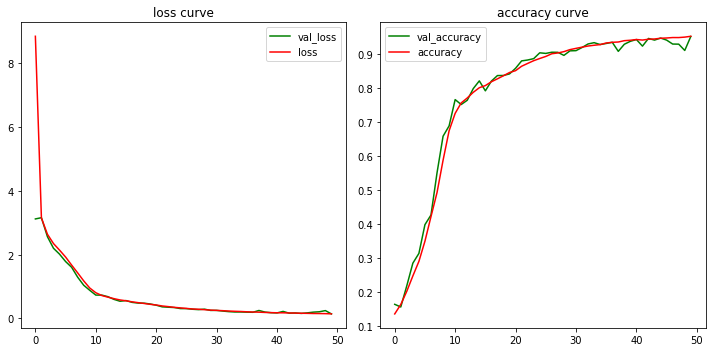

991/991 [==============================] - 253s 255ms/step - loss: 0.1453 - accuracy: 0.9524 - val_loss: 0.1430 - val_accuracy: 0.9519


In [38]:
train_load = DataLoader(PATH+'Train/')
train = train_load.flow(batch_size=64)

history = model.fit(train,
                    steps_per_epoch = int(len(os.listdir(PATH+'Train/'))/64),
                    epochs=50,
                    validation_data=(val_X,val_Y),
                    callbacks=[chckpt,loss_cback],verbose=1
                    )

# Model Test with Unseen Image

(2000, 3008, 3)


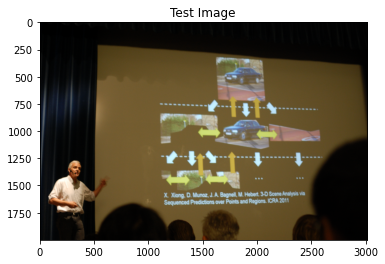

In [148]:
im = cv2.cvtColor(cv2.imread('/content/re08ec168t.TIF'),cv2.COLOR_BGR2RGB)
plt.imshow(im);
plt.title("Test Image");
print(im.shape)

In [141]:
def prepare_eval(image_list,crop_size=256,rfs= CAND_RF):
  images = []
  for im in image_list:
    img = cv2.cvtColor(cv2.imread('/content/'+im),cv2.COLOR_BGR2RGB)
    for i in range(crop_size,img.shape[0],crop_size):
        for j in range(crop_size,img.shape[1],crop_size):
            images.append(img[i-crop_size:i,j-crop_size:j,:])
  resized_images = []
  labels = []
  for im in images:
    for rf in np.random.choice(rfs,5,replace=False):
      label = np.zeros(10)
      label[CAND_RF.index(rf)]=1
      labels.append(label)
      r_img = cv2.resize(im,(int(im.shape[0]*rf),int(im.shape[1]*rf)),interpolation=cv2.INTER_CUBIC)
      r_img = cv2.cvtColor(r_img,cv2.COLOR_RGB2YCrCb)[:128,:128,0]
      resized_images.append(np.expand_dims(r_img,axis=2))
  return np.stack(resized_images),np.stack(labels)

X_eval,Y_eval = prepare_eval(['re08ec168t.TIF'])

In [142]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

In [143]:
model.load_weights('model.hdf5')
pred = model.predict(X_eval)
pred = [np.argmax(p) for p in pred]

In [144]:
y = [np.argmax(p) for p in Y_eval]

In [145]:
print(accuracy_score(y,pred))

0.9714285714285714


In [63]:
print(f'predicted: {CAND_RF[np.argmax(model.predict(np.stack([test_img])))]}')
t = CAND_RF[np.argmax(Y_eval[0])]
print(f'True: {t}')

predicted: 0.6
True: 0.6
